# Машинное обучение, ММП ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 09.12.2019

Мягкий дедлайн: 23:59MSK 22.12.2019

Жесткий дедлайн: 23:59MSK 29.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.65511372061709

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [40]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    lenw, lenh = X.shape
    
    mas_sums = np.zeros(lenw, dtype=np.float64)
    mas_sq_sums = mas_sums.copy()
    mas_out_of_bag = np.zeros(lenw, dtype=np.int32)
    error_sum = 0
    pred_size = 0
    
    for i in range(num_runs):
        ind = np.random.randint(0, lenw, lenw)
        ind_out_of_bag = np.setdiff1d(np.arange(lenw), ind)
        
        regressor.fit(X[ind], y[ind])
        pred_out_of_bag = regressor.predict(X[ind_out_of_bag])
        
        mas_sums[ind_out_of_bag] += pred_out_of_bag
        mas_sq_sums[ind_out_of_bag] += np.square(pred_out_of_bag)
        mas_out_of_bag[ind_out_of_bag] += 1
        
        error_sum += np.square(pred_out_of_bag - y[ind_out_of_bag]).sum()
        pred_size += ind_out_of_bag.size
    bias = np.square(mas_sums / mas_out_of_bag - y).mean()
    variance = (mas_sq_sums / mas_out_of_bag - np.square(mas_sums/mas_out_of_bag)).mean()
    err = error_sum / pred_size

    return bias, variance, err

**Задание 2. (1 балл)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [42]:
regressors = {
    'LinearRegression': LinearRegression(), 
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

for regressor_name in regressors:
    bias, variance, error = compute_biase_variance(regressors[regressor_name], X, y, num_runs=1000)
    print("{}:".format(regressor_name))
    print("\tBias = {:.5}".format(bias))
    print("\tVariance = {:.5}".format(variance))
    print("\tLoss = {:.5}".format(error))

LinearRegression:
	Bias = 23.696
	Variance = 0.90896
	Loss = 24.438
DecisionTreeRegressor:
	Bias = 10.232
	Variance = 13.044
	Loss = 23.363


C:\Users\Lev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor:
	Bias = 10.609
	Variance = 3.4031
	Loss = 14.033


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__

- Мы можем приближенно оценить ошибку регрессии рассматривая сдвиг и разброс
- Линейная регресия имеет большой сдвиг, но при этом маленький разброс. Возможно это связанно с рассматриваемыми данными и не ленейной зависимостью между ними
- Обычное дерево же наоборот маленький сдвиг и больший разброс(по сравнению с ленейной регрессией), так как дерево плохо обобщает данные выборки
- Ансамбль деревьев должен теоритически уменьшить разброс что и проказано в эксперименте

Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

Теоритически разброс должен уменьшаться в 10 раз, но это в идеале в нашем случае разброс уменьшился в 3.8 раза, так как такое уменьшение разброса теоретически связанно с тем что полученные деревья мало коррелируют. В нашем же случае это не так.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [71]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, ax=None, title=""):
    lenw, lenh = X.shape
    test_ind = np.random.choice(lenw, num_test_objects, replace=False)
    train_ind = np.setdiff1d(np.arange(lenw), test_ind)
    
    X_train, X_test = X[train_ind], X[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]
    
    wXtrain, hXtrain = X_train.shape
    wXtest, hXtest = X_test.shape
    
    sampl = np.zeros((num_runs, wXtest))
    
    for i in range(num_runs):
        ind = np.random.randint(0, wXtrain, wXtrain)
        regressor.fit(X_train[ind], y_train[ind])
        sampl[i] = regressor.predict(X_test)
    
    ax.set_title(title)
    ax.set_xlabel("objects")
    ax.set_ylabel("prediction")
    ax.set_xticks(np.arange(num_test_objects))
    for i in range(X_test.shape[0]):
        ax.scatter(np.ones(num_runs)*i, sampl[:, i])
        ax.scatter([i], y_test[i], c="black", marker="D")

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

C:\Users\Lev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


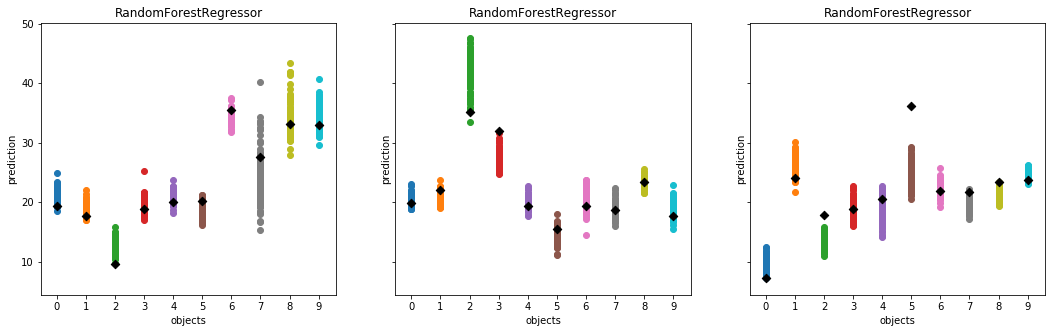

In [72]:
regressors = {
    'LinearRegression': LinearRegression(), 
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

for i, reg_name in enumerate(regressors):
    plot_predictions(regressors[regressor_name], X, y, num_runs=100, num_test_objects=10, title=regressor_name, ax=axes[i])
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [127]:
from sklearn.model_selection import train_test_split

In [128]:
data = pd.read_csv('application_train.csv')
y = data["TARGET"]
data = data.drop(columns=["TARGET"])

#что удалять вообще непонятно, взял только числовые
X = data.select_dtypes(['number'])

data = X.fillna(X.median())

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Почему получилась заметная разница в качестве?**

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [130]:
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier
import time
from sklearn.metrics import average_precision_score

In [131]:
def fit_and_clasifier(classifier, classifier_name):
    print("{}:".format(classifier_name))
    start = time.time()
    classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)
    pr_auc = average_precision_score(y_test, y_pred_proba[:, 1])
    print("\tAccuracy: {}".format(pr_auc))
    print("\tTime: {}".format(time.time() - start))
    return pr_auc

In [132]:
classifiers = {
    'LightGBM': LGBMClassifier(), 
    'Catboost': CatBoostClassifier(silent=True)
}

for classifier_name in classifiers:
    fit_and_clasifier(classifiers[classifier_name], classifier_name)

LightGBM:
	Accuracy: 0.23873352261026387
	Time: 8.077202796936035
Catboost:
	Accuracy: 0.24219684017638732
	Time: 141.9190948009491


**Your answer here:**
Единственная заметная разница получилась по скорости работы этих двух алгоритмов. Все таки 8.5 против 109. Качество же сильно не изменилось, хоть и вырасло при использованиии Catboost.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

In [139]:
classifiers = {
    'LightGBM': LGBMClassifier(), 
    'Catboost': CatBoostClassifier(silent=True)
}
count_trees = [1, 10, 50, 100, 200, 300, 400, 500]
depth = [1, 2, 3, 4, 5, 7, 9, 11]

In [140]:
def classifier_with_param(name_classifier, count_trees, depth):
    lenCountTrees = len(count_trees)
    lenDepth = len(depth)
    grid_acc = np.zeros((lenCountTrees, lenDepth))
    grid_time = np.zeros((lenCountTrees, lenDepth))
    for i in range(lenCountTrees):
        for j in range(lenDepth):
            clf = None
            if name_classifier == "LightGBM":
                clf = LGBMClassifier(n_estimators=count_trees[i], max_depth=depth[j])
            elif name_classifier == "Catboost":
                clf = CatBoostClassifier(iterations=count_trees[i], max_depth=depth[j], silent=True)
            print("\r Trees: {}/{}, Depth: {}/{}".format(i, lenCountTrees, 
                                                         j, lenDepth))
            start = time.time()
            clf.fit(X_train, y_train)
            grid_time[i,j] = time.time() - start
            y_pred = clf.predict_proba(X_test)
            auc = average_precision_score(y_test, y_pred[:, 1])
            grid_acc[i,j] = auc
        print(grid_time[i])
        print(grid_acc[i])
    return grid_acc, grid_time

In [141]:
print("LightGBM")
gbm_acc, gbm_time = classifier_with_param("LightGBM", count_trees, depth)

LightGBM
 Trees: 0/8, Depth: 0/8
 Trees: 0/8, Depth: 1/8
 Trees: 0/8, Depth: 2/8
 Trees: 0/8, Depth: 3/8
 Trees: 0/8, Depth: 4/8
 Trees: 0/8, Depth: 5/8
 Trees: 0/8, Depth: 6/8
 Trees: 0/8, Depth: 7/8
[1.78096962 1.74838686 1.88547492 1.6447196  1.75348258 1.71203613
 1.68284893 1.99799705]
[0.10838942 0.13922578 0.16347007 0.17259011 0.18159559 0.18700711
 0.18700711 0.18700711]
 Trees: 1/8, Depth: 0/8
 Trees: 1/8, Depth: 1/8
 Trees: 1/8, Depth: 2/8
 Trees: 1/8, Depth: 3/8
 Trees: 1/8, Depth: 4/8
 Trees: 1/8, Depth: 5/8
 Trees: 1/8, Depth: 6/8
 Trees: 1/8, Depth: 7/8
[1.99982953 1.97685885 1.98590732 2.5280962  2.54833198 2.69361973
 2.82056499 3.16105199]
[0.17416461 0.18800392 0.20083516 0.20392995 0.21348236 0.21861285
 0.21933197 0.21941586]
 Trees: 2/8, Depth: 0/8
 Trees: 2/8, Depth: 1/8
 Trees: 2/8, Depth: 2/8
 Trees: 2/8, Depth: 3/8
 Trees: 2/8, Depth: 4/8
 Trees: 2/8, Depth: 5/8
 Trees: 2/8, Depth: 6/8
 Trees: 2/8, Depth: 7/8
[2.91610456 3.32057548 3.78411818 4.45103097 5.2530

In [143]:
print("Catboost")
cat_acc, cat_time = classifier_with_param("Catboost", count_trees, depth)

Catboost
 Trees: 0/8, Depth: 0/8
 Trees: 0/8, Depth: 1/8
 Trees: 0/8, Depth: 2/8
 Trees: 0/8, Depth: 3/8
 Trees: 0/8, Depth: 4/8
 Trees: 0/8, Depth: 5/8
 Trees: 0/8, Depth: 6/8
 Trees: 0/8, Depth: 7/8
[1.07723451 0.7580204  0.8124218  0.88295078 0.86548781 0.88601136
 1.1282568  1.56963587]
[0.07971035 0.10664283 0.11410997 0.12078113 0.12121348 0.13502351
 0.13508634 0.13781642]
 Trees: 1/8, Depth: 0/8
 Trees: 1/8, Depth: 1/8
 Trees: 1/8, Depth: 2/8
 Trees: 1/8, Depth: 3/8
 Trees: 1/8, Depth: 4/8
 Trees: 1/8, Depth: 5/8
 Trees: 1/8, Depth: 6/8
 Trees: 1/8, Depth: 7/8
[1.17512298 1.26994133 1.5974431  1.47954416 1.61607766 2.02459407
 2.94322491 9.2163403 ]
[0.1725594  0.1961263  0.21321224 0.21833584 0.21871279 0.22605114
 0.21986386 0.21716062]
 Trees: 2/8, Depth: 0/8
 Trees: 2/8, Depth: 1/8
 Trees: 2/8, Depth: 2/8
 Trees: 2/8, Depth: 3/8
 Trees: 2/8, Depth: 4/8
 Trees: 2/8, Depth: 5/8
 Trees: 2/8, Depth: 6/8
 Trees: 2/8, Depth: 7/8
[ 3.24252844  3.63530469  4.10989237  4.66001678  5

In [144]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [145]:
print(cat_acc)
print(gbm_acc)

[[0.07971035 0.10664283 0.11410997 0.12078113 0.12121348 0.13502351
  0.13508634 0.13781642]
 [0.1725594  0.1961263  0.21321224 0.21833584 0.21871279 0.22605114
  0.21986386 0.21716062]
 [0.21815425 0.2340551  0.24015438 0.23523173 0.23089584 0.22438774
  0.20863657 0.1889005 ]
 [0.22872609 0.23676629 0.23820963 0.2313623  0.22475954 0.21555786
  0.19476816 0.17392713]
 [0.23074712 0.24042118 0.24227383 0.23909331 0.23471985 0.22200516
  0.20890538 0.18279185]
 [0.23183071 0.24156331 0.24365378 0.24027991 0.23929318 0.23242649
  0.21357246 0.19756308]
 [0.23206896 0.24228173 0.24378393 0.24241717 0.24070982 0.23493545
  0.2188903  0.20489032]
 [0.23186369 0.24233483 0.24306422 0.24238403 0.23919402 0.23265555
  0.21985171 0.20490021]]
[[0.10838942 0.13922578 0.16347007 0.17259011 0.18159559 0.18700711
  0.18700711 0.18700711]
 [0.17416461 0.18800392 0.20083516 0.20392995 0.21348236 0.21861285
  0.21933197 0.21941586]
 [0.20667706 0.22096926 0.22933628 0.23177128 0.23698133 0.23803253
 

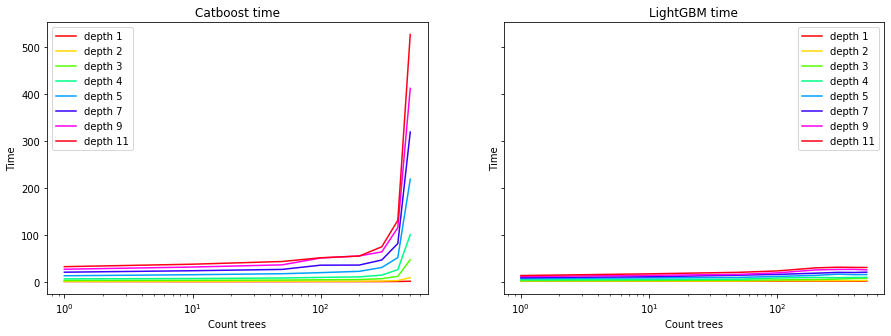

In [146]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
num_val = cat_time.shape[0]
cmap = get_cmap(num_val)

ax[0].set_title("Catboost time")
ax[0].set_xlabel("Count trees")
ax[0].set_ylabel("Time")
ax[0].set_xscale('log', basex = 10)
for i in range(cat_time.shape[0]):
    ax[0].plot(count_trees, cat_time[i],  color=cmap(i), label="depth {}".format(depth[i]))
ax[0].legend()
    
ax[1].set_title("LightGBM time")
ax[1].set_xlabel("Count trees")
ax[1].set_ylabel("Time")
ax[1].set_xscale('log', basex = 10)
for i in range(gbm_time.shape[0]):
    ax[1].plot(count_trees, gbm_time[i],  color=cmap(i), label="depth {}".format(depth[i]))
ax[1].legend()

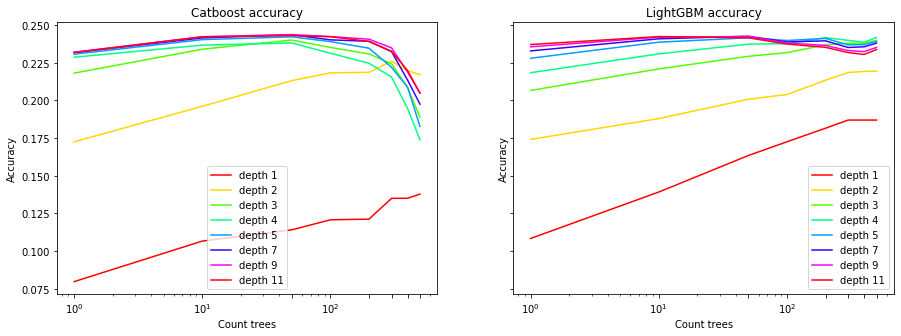

In [148]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
num_val = cat_time.shape[0]
cmap = get_cmap(num_val)

cat_min_val = np.min(cat_acc)
cat_max_val = np.max(cat_acc)

ax[0].set_title("Catboost accuracy")
ax[0].set_xlabel("Count trees")
ax[0].set_ylabel("Accuracy")
ax[0].set_xscale('log', basex = 10)
ax[0].set_xticks(count_trees)
for i in range(cat_acc.shape[0]):
    ax[0].plot(count_trees, cat_acc[i],  color=cmap(i), label="depth {}".format(depth[i]))
ax[0].legend()
    
gbm_min_val = np.min(gbm_acc)
gbm_max_val = np.max(gbm_acc)
    
ax[1].set_title("LightGBM accuracy")
ax[1].set_xlabel("Count trees")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale('log', basex = 10)
ax[1].set_xticks(count_trees)
for i in range(gbm_acc.shape[0]):
    ax[1].plot(count_trees, gbm_acc[i],  color=cmap(i), label="depth {}".format(depth[i]))
ax[1].legend()

**Your answer here:**
- Исходя из эксперимента видно что алгоритмы дают примерно сопоставимую точность
- Увеличение числа деревьев не дает прирость точности после где то 150, а даже уменьшает ее
- Глубина дает относительно сопоставимое качество 5-6, но увеличивает время работы особенно это заметно на Catboost
- Также увеличение времени работы дает использование большого числа деревьев на графике Catboost рост очень похож на экспоненту